## TMDB - Systematische Evaluierung

In [123]:
import pandas as pd
import numpy as np
from datetime import datetime

In [100]:
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

In [101]:
# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


In [102]:
# extract data from dictionaries and list, separate key values by '|'

def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))

df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

# belongs_to_collection

In [103]:
# adult is dropped because there are only 3 adult films. which makes it useless to use for our model
cols = [
    "imdbId",
    "Unnamed: 0",
    "backdrop_path",
    "homepage",
    "poster_path",
    "imdb_id",
    "original_title",
    "video",
    "status",
    "adult"
]

# drop unused columns
df_movies2 = df_movies.drop(df_movies[cols], axis=1)

In [104]:
# reorder columns
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "tagline",
    "release_date", 
    "vote_average", 
    "vote_count", 
    "popularity", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
    "revenue",
    "budget",
    "belongs_to_collection",
    
]

df_movies2 = df_movies2[col_order]

In [107]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df2 = df2.drop_duplicates(subset=df2.columns.difference(['movieId']))

In [108]:
# replace empty field with np.nan
df2 = df2.replace("", np.nan)

In [109]:
# print number of NA's in each column
print(df2.isna().sum())

movieId                      0
title                        0
genres                     320
overview                   161
tagline                  11164
release_date                 0
vote_average                 0
vote_count                   0
popularity                   0
runtime                      0
original_language            0
spoken_languages          1131
production_companies      3610
production_countries      1869
revenue                      0
budget                       0
belongs_to_collection    18069
dtype: int64


In [110]:
# drop rows with NAN overview --> these values are very important for the recommender model
df2 = df2.dropna(subset=['overview'])

## User Profiles

In [127]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

In [128]:
lst_movieId = list(df2["movieId"])

# remove ratings from movies that we are not using
df_ratings = df_ratings[df_ratings["movieId"].isin(lst_movieId)]

# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

# merge movies and ratings
df3 = pd.merge(df_ratings, df2, on = "movieId")

In [129]:
# drop rows where the ratings were submitted before the movie even released
df3 = df3[df3["date"] > df3["release_date"]]

# drop columns because they are useless now
df3.drop(["date", "release_date"], axis = 1, inplace = True)

In [130]:
# No user has rated the same movie twice
df3[df3.duplicated(subset=["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection


In [131]:
df3

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651779,162067,200634,2.5,Eddie's Life Coach,Family|Animation,Eddie's mom signs her slacker son up for a dig...,NaN,5.500,6,1.691,4,en,English,Illumination,United States of America,0,0,NaN
2651780,162358,200168,3.0,Overtime War,Action|Comedy,Benefits and days off in war.,NaN,6.500,2,0.600,5,sv,svenska,Crazy Pictures,Sweden,0,0,NaN
2651781,162358,200172,4.0,Du ritar fult,Drama,"""You can't draw"", said the classmate. He didn'...",NaN,6.750,8,0.869,6,sv,NaN,Crazy Pictures,Sweden,0,0,NaN
2651782,162358,200182,4.0,Kuken brinner,Drama,Anders is in the hospital waiting nervously fo...,NaN,6.000,3,0.600,6,sv,svenska,Crazy Pictures,Sweden,0,0,NaN


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651779,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2651780,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2651781,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2651782,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Testing

In [12]:
# Programmierungs Fragen
# delete movies without genres (320 movies). correct?
# tagline more relevant then overview?
# 300 + movies with 0 runtime
# amount of ratings --> drop movies with under 10 vote counts?? (4000 movies)
# Venice movie duplicate --> why are you here?? are there other duplicates?
# Many movies with 0 revenue and 0 budget
# movie cast??
# ratings.csv von github lesen --> git lfs

# Generelle Fragen
# Wie beheben wir das Cold Start Problem? -

## EDA

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Welches sind die am häufigsten geschauten Genres/Filme?


In [210]:
dum = df3['genres'].str.get_dummies(sep = '|')
df4 = pd.concat([df3, dum], axis=1) 

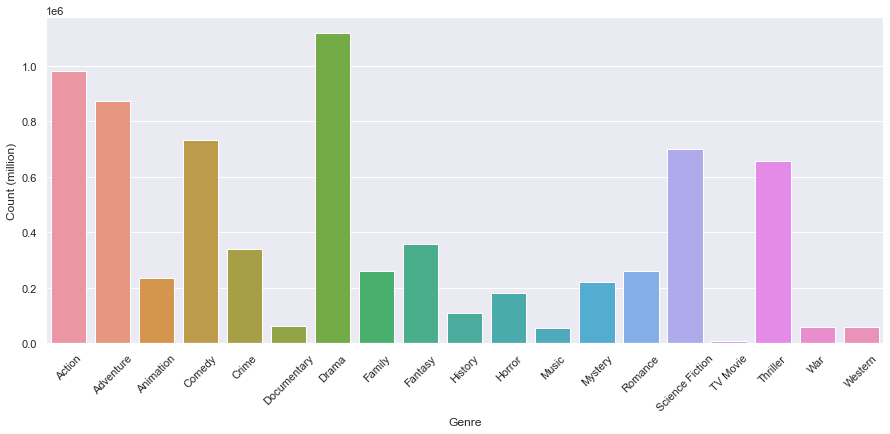

In [219]:
sns.set(rc={'figure.figsize':(15,6)})

ax = sns.barplot(data = df4.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)
ax.set(xlabel='Genre', ylabel='Count (million)')
plt.xticks(rotation = 45)
plt.show()

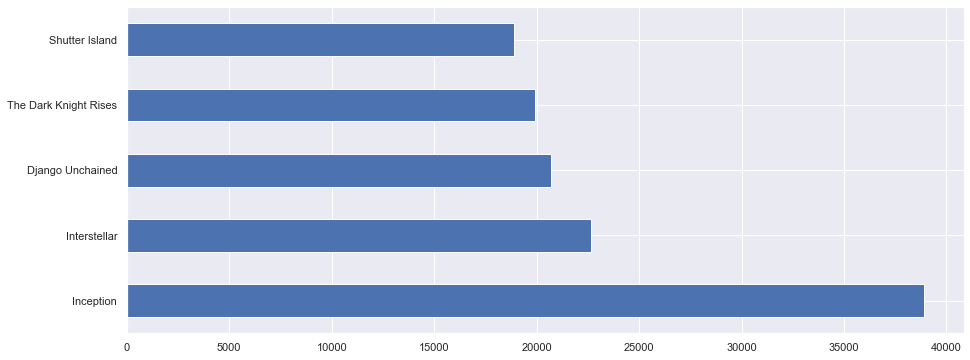

In [201]:
df3['title'].value_counts()[:5].plot(kind = "barh")
plt.show()

### 2. Wie verteilen sich die Kundenratings gesamthaft und nach Genres?


In [ ]:
sns.set(rc={'figure.figsize':(15,6)})

ax = sns.barplot(data = df4.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)
ax.set(xlabel='Genre', ylabel='Count (million)')
plt.xticks(rotation = 45)
plt.show()